
# 070. 컴퓨터 비전(Vision)을 위한 전이학습(Transfer Learning)
=======================================================

- 실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에,(무작위 초기화를 통해) 맨 처음부터 합성곱 신경망(Convolutional Network) 전체를 작성하는 경우는 매우 적다. 
- 대신, 매우 큰 데이터셋(예. 100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱 신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업을 위한 초기 설정 또는 고정된 특징 추출기(fixed feature extractor)로 사용

### 전이학습의 2 가지 시나리오:

-  **합성곱 신경망의 미세조정(finetuning)**: 신경망을 ImageNet 등으로 미리 학습한 신경망으로 초기화하고 parameter 미세 조정
-  **고정된 특징 추출기로써의 합성곱 신경망**: 마지막 완전 연결층을 제외한 모든 신경망의 가중치를 고정. 마지막의 완전 연결층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tensorflow as tf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

데이터 불러오기
---------------

- **개미** 와 **벌** 을 분류하는 모델을 학습
    - 대략 120장 정도의 훈련 이미지와, 75장의 검증용 이미지를 이용
    - 전이학습을 통해 소량의 데이터로도 일반화 가능
    - ImageNet의 일부 data 이용

.. Note ::
   데이터를 [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   에서 다운로드 받아 현재 디렉토리에 압축을 푼다

In [2]:
_URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
path_to_zip = tf.keras.utils.get_file('/content/sample_data/hymenoptera_data.zip', origin=_URL, 
                                      extract=True, cache_dir='/content/sample_data')

In [3]:
# 데이터 증가(augmentation) 및 normalization 적용
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# ImageFolder 라이브러리

- 계층적인 폴더 구조를 가지고 있는 데이터셋을 불러올 때 사용할 수 있다. 각 이미지들이 자신의 레이블(Label) 이름으로 된 폴더 안에 들어가 있는 구조라면, ImageFolder 라이브러리를 이용하여 이를 바로 불러와 객체로 만들면 된다.

In [4]:
data_dir = '/content/sample_data/datasets/hymenoptera_data'
train_dir = os.path.join(data_dir, 'train')
val_dir  = os.path.join(data_dir, 'val')

print(os.listdir(data_dir))
print(os.listdir(train_dir))
print(os.listdir(val_dir))

['val', 'train']
['bees', 'ants']
['bees', 'ants']


### datasets.ImageFolder(folder, transform) data loader 생성

In [5]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), 
                                          data_transforms['train']) 
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), 
                                          data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_data, 
                                batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, 
                                batch_size=16, shuffle=True)

In [6]:
class_names = train_data.classes
class_names

['ants', 'bees']

In [7]:
print(len(train_data), len(val_data))
print(class_names)

244 153
['ants', 'bees']


### 일부 이미지 시각화하기

In [8]:
def imshow(inp, title=None):
    plt.figure(figsize=(12, 4))
    inp = inp.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = inp * std + mean
    inp  = np.clip(inp, 0, 1)
    plt.title(title)
    plt.imshow(inp)

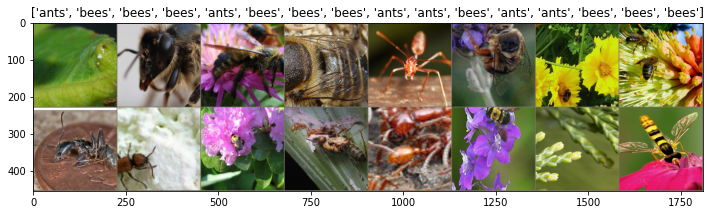

In [9]:
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, [class_names[x] for x in classes])

Model Train
--------------

-  학습율(learning rate) 관리(scheduling)
-  최적의 모델 구하기

- 아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR 스케쥴러 객체(Object)

## 1. 합성곱 신경망 미세조정(finetuning)

- 미리 학습한 모델을 불러온 후 마지막의 완전 연결층을 초기화

### torch 제공 pre-trained models
```
    import torchvision.models as models  
    
    resnet18 = models.resnet18()  
    alexnet = models.alexnet()  
    vgg16 = models.vgg16()  
    squeezenet = models.squeezenet1_0()  
    densenet = models.densenet161()  
    inception = models.inception_v3()  
    googlenet = models.googlenet()  
    shufflenet = models.shufflenet_v2_x1_0()  
    mobilenet = models.mobilenet_v2()  
    resnext50_32x4d = models.resnext50_32x4d()  
    wide_resnet50_2 = models.wide_resnet50_2()  
    mnasnet = models.mnasnet1_0()  
```   

In [10]:
model_ft = torchvision.models.resnet18(pretrained=True)

num_features = model_ft.fc.in_features
num_features

512

In [11]:
# 여기서 fc layer 출력의 크기를 1000 에서 2로 변경
model_ft.fc = nn.Linear(num_features, 2)
model_ft.fc

Linear(in_features=512, out_features=2, bias=True)

In [12]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1 비율로 learning rate decay
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    st = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        model.train()  # 모델을 학습 모드로 설정
        cost = 0
        corrects = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            z = model(x)
            _, preds = torch.max(z, 1)
            
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()

            cost += loss.item() * x.size(0)
            corrects += torch.sum(preds == y)

        train_acc = corrects / len(train_data)  
        train_loss = cost / len(train_data)
        
        scheduler.step()

        model.eval()  # 모델을 학습 모드로 설정
        cost = 0
        corrects = 0
        
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)

                z = model(x)
                _, preds = torch.max(z, 1)

                loss = criterion(z, y)

                cost += loss.item() * x.size(0)
                corrects += torch.sum(preds == y)

        val_acc  = corrects / len(val_data)    
        val_loss = cost / len(val_data)

        print(f'eEpoch {epoch+1}/{num_epochs}==> train loss: {train_loss:.4f} ' + 
              f'val loss: {val_loss:.4f} ' + f'train acc: {train_acc:.2f} ' + 
              f'val acc: {val_acc:.2f}')

        # 모델을 깊은 복사(deep copy)함
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - st
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=25)

Epoch 0/24
----------
eEpoch 1/25==> train loss: 0.6524 val loss: 0.3325 train acc: 0.66 val acc: 0.87
Epoch 1/24
----------
eEpoch 2/25==> train loss: 0.2908 val loss: 0.2186 train acc: 0.88 val acc: 0.93
Epoch 2/24
----------
eEpoch 3/25==> train loss: 0.2297 val loss: 0.1933 train acc: 0.90 val acc: 0.94
Epoch 3/24
----------
eEpoch 4/25==> train loss: 0.1946 val loss: 0.1891 train acc: 0.93 val acc: 0.92
Epoch 4/24
----------
eEpoch 5/25==> train loss: 0.1815 val loss: 0.1704 train acc: 0.93 val acc: 0.95
Epoch 5/24
----------
eEpoch 6/25==> train loss: 0.1781 val loss: 0.1468 train acc: 0.95 val acc: 0.95
Epoch 6/24
----------
eEpoch 7/25==> train loss: 0.1942 val loss: 0.1653 train acc: 0.93 val acc: 0.95
Epoch 7/24
----------
eEpoch 8/25==> train loss: 0.1065 val loss: 0.1675 train acc: 0.96 val acc: 0.94
Epoch 8/24
----------
eEpoch 9/25==> train loss: 0.1580 val loss: 0.1711 train acc: 0.94 val acc: 0.95
Epoch 9/24
----------
eEpoch 10/25==> train loss: 0.1028 val loss: 0.1717

In [16]:
predictions = []
labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        z = model_ft(x)
        _, preds = torch.max(z, 1)
        
        predictions.extend(preds.cpu().numpy())
        labels.extend(y.cpu().numpy())
        
    correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
    incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

print("accuracy = %.2f %%" % (len(correct_indices) / len(predictions) * 100))

accuracy = 95.42 %


<Figure size 432x216 with 0 Axes>

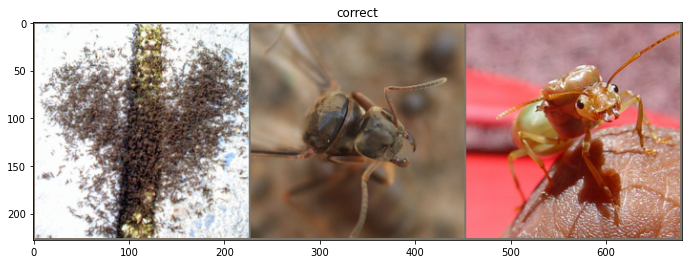

<Figure size 432x216 with 0 Axes>

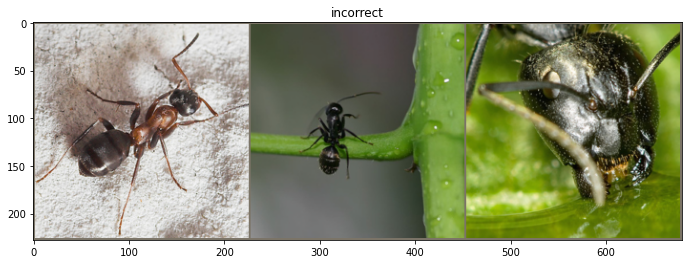

In [17]:
inputs = []
for i, idx in enumerate(correct_indices[:3]):
    inputs.append(val_data[idx][0])
out = torchvision.utils.make_grid(inputs, nrow=3)
plt.figure(figsize=(6, 3))
imshow(out, 'correct')

inputs = []
for i, idx in enumerate(incorrect_indices[:3]):
    inputs.append(val_data[idx][0])
out = torchvision.utils.make_grid(inputs, nrow=3)
plt.figure(figsize=(6, 3))
imshow(out, 'incorrect')